In [6]:
! pip3 install rdkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import random
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold
from pathlib import Path
from warnings import filterwarnings

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, PandasTools

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from torch.utils.data import Dataset
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
# Use a theme
plt.style.use('ggplot')

filterwarnings("ignore")
filename = "BBBP.csv"

In [7]:
# for run in kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        filename = (os.path.join(dirname, filename))

In [8]:
df = pd.read_csv(filename)
df = df[['name', 'smiles', 'p_np']]
df.head(3)

,name,smiles,p_np
0,Propanolol,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1
1,Terbutylchlorambucil,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1
2,40730,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1


In [9]:
def assess_two_letter_elements(df):
    # Search for unique characters in SMILES strings
    unique_chars = set(df.smiles.apply(list).sum())
    # Get upper and lower case letters only
    upper_chars = []
    lower_chars = []
    for entry in unique_chars:
        if entry.isalpha():
            if entry.isupper():
                upper_chars.append(entry)
            elif entry.islower():
                lower_chars.append(entry)
    print(f"Upper letter characters {sorted(upper_chars)}")
    print(f"Lower letter characters {sorted(lower_chars)}")

    # List of all possible periodic elements
    periodic_elements = [
        "Ac","Al","Am","Sb","Ar","As","At","Ba","Bk","Be","Bi","Bh","B",
        "Br","Cd","Ca","Cf","C","Ce","Cs","Cl","Cr","Co","Cn","Cu","Cm",
        "Ds","Db","Dy","Es","Er","Eu","Fm","Fl","F","Fr","Gd","Ga","Ge",
        "Au","Hf","Hs","He","Ho","H","In","I","Ir","Fe","Kr","La","Lr",
        "Pb","Li","Lv","Lu","Mg","Mn","Mt","Md","Hg","Mo","Mc","Nd","Ne",
        "Np","Ni","Nh","Nb","N","No","Og","Os","O","Pd","P","Pt","Pu",
        "Po","K","Pr","Pm","Pa","Ra","Rn","Re","Rh","Rg","Rb","Ru","Rf",
        "Sm","Sc","Sg","Se","Si","Ag","Na","Sr","S","Ta","Tc","Te","Ts",
        "Tb","Tl","Th","Tm","Sn","Ti","W","U","V","Xe","Yb","Y","Zn","Zr",]

    # The two_char_elements list contains all two letter elements
    # which can be generated by all possible combination of upper x lower characters
    # and are valid periodic elements.
    two_char_elements = []
    for upper in upper_chars:
        for lower in lower_chars:
            ch = upper + lower
            if ch in periodic_elements:
                two_char_elements.append(ch)

    # This list is then reduced to the subset of two-letter elements
    # that actually appear in the SMILES strings, specific to our data set.
    two_char_elements_smiles = set()
    for char in two_char_elements:
        if df.smiles.str.contains(char).any():
            two_char_elements_smiles.add(char)

    return two_char_elements_smiles



In [10]:
elements_found = assess_two_letter_elements(df)
print(f"\nTwo letter elements found in the data set: {sorted(elements_found)}")

Upper letter characters ['B', 'C', 'F', 'H', 'I', 'N', 'O', 'P', 'S']
Lower letter characters ['a', 'c', 'l', 'n', 'o', 'r', 's']

Two letter elements found in the data set: ['Br', 'Ca', 'Cl', 'Cn', 'Na', 'Sc']


In [11]:
replace_dict = {"Cl": "L", "Br": "R", "Se": "X", "@@": "Z"}
def preprocessing_data(df, replacement):
    # Create a new column having processed canonical SMILES
    df["processed_smiles"] = df["smiles"].copy()

    # Replace the two letter elements found with one character
    for pattern, repl in replacement.items():
        df["processed_smiles"] = df["processed_smiles"].str.replace(pattern, repl)

    unique_char = set(df.processed_smiles.apply(list).sum())
    return df, unique_char
df, unique_char = preprocessing_data(df, replace_dict)
df.head(3)

,name,smiles,p_np,processed_smiles
0,Propanolol,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1,[L].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL
2,40730,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
# Print unique characters
print(f"All unique characters found in the data set:\n{sorted(unique_char)}")
print(len(unique_char))

All unique characters found in the data set:
['#', '%', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', '@', 'B', 'C', 'F', 'H', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'Z', '[', '\\', ']', 'a', 'c', 'n', 'o', 's']
40


In [13]:
longest_smiles = max(df["smiles"], key=len)
longest_smiles_index = df.smiles[df.smiles == longest_smiles].index.tolist()
print(f"Longest SMILES: {longest_smiles}")

shortest_smiles = min(df["smiles"], key=len)
shortest_smiles_index = df.smiles[df.smiles == shortest_smiles].index.tolist()
print(f"Shortest SMILES: {shortest_smiles}")
longest_smiles_p = max(df["processed_smiles"], key=len)
shortest_smiles_p = min(df["processed_smiles"], key=len)
smiles_p_maxlen = len(longest_smiles_p)

Longest SMILES: CCC(C)[C@H]1O[C@]2(CC[C@@H]1C)CC3C[C@@H](C\C=C(C)\[C@@H](O[C@H]4C[C@H](OC)[C@@H](OC5C[C@H](OC)[C@@H](O)[C@H](C)O5)[C@H](C)O4)[C@@H](C)/C=C/C=C/6CO[C@@H]7[C@H](O)C(=C[C@@H](C(=O)O3)[C@]67O)C)O2.CO[C@H]8CC(O[C@@H](C)[C@@H]8O)O[C@H]9[C@H](C)O[C@H](C[C@@H]9OC)O[C@H]/%10[C@@H](C)/C=C/C=C/%11CO[C@@H]%12[C@H](O)C(=C[C@@H](C(=O)OC%13C[C@@H](C\C=C%10C)O[C@@]%14(CC[C@H](C)[C@H](O%14)C(C)C)C%13)[C@]%11%12O)C
Shortest SMILES: CCO


In [14]:

print(f"The longest SMILES string Contains {len(longest_smiles)} characters, index in dataframe: {longest_smiles_index[0]}.")
print(f"The shortest SMILES string Contains {len(shortest_smiles)} characters, index in dataframe: {shortest_smiles_index[0]}.")
print('after processing')
print(f"The longest SMILES string after processing Contains {len(longest_smiles_p)} characters.")
print(f"The shortest SMILES string after processing Contains {len(shortest_smiles_p)} characters.")


The longest SMILES string Contains 400 characters, index in dataframe: 826.
The shortest SMILES string Contains 3 characters, index in dataframe: 454.
after processing
The longest SMILES string after processing Contains 384 characters.
The shortest SMILES string after processing Contains 3 characters.


In [15]:
tokens = df['processed_smiles'].apply(list)
counter = Counter(token for tokens_list in tokens for token in tokens_list)

In [16]:
unique_chars = np.array(list(counter.keys())).reshape(-1, 1)
encoder = OneHotEncoder( sparse_output=False)
encoded_Unique_smiles = encoder.fit_transform(unique_chars)
print('one hot matrix shape:',encoded_Unique_smiles.shape)

one hot matrix shape: (40, 40)


In [17]:
print('number of tokens:',len((list(counter.keys()))))
for token, freq in counter.items():
    print(f"Character: {token} => Frequency: {freq}")

number of tokens: 40
Character: [ => Frequency: 3479
Character: L => Frequency: 618
Character: ] => Frequency: 3479
Character: . => Frequency: 163
Character: C => Frequency: 29784
Character: ( => Frequency: 10491
Character: ) => Frequency: 10491
Character: N => Frequency: 3954
Character: O => Frequency: 6208
Character: c => Frequency: 6937
Character: 1 => Frequency: 4128
Character: 2 => Frequency: 3370
Character: = => Frequency: 8034
Character: 3 => Frequency: 2553
Character: 4 => Frequency: 1438
Character: F => Frequency: 509
Character: n => Frequency: 515
Character: o => Frequency: 49
Character: @ => Frequency: 1692
Character: H => Frequency: 2392
Character: S => Frequency: 510
Character: Z => Frequency: 1251
Character: 5 => Frequency: 454
Character: \ => Frequency: 203
Character: / => Frequency: 184
Character: s => Frequency: 72
Character: # => Frequency: 53
Character: R => Frequency: 51
Character: I => Frequency: 6
Character: + => Frequency: 121
Character: - => Frequency: 123
Chara

In [18]:
unique_chars = np.array(list(counter.keys())).reshape(-1, 1)
encoder = OneHotEncoder( sparse_output=False)
encoded_Unique_smiles = encoder.fit_transform(unique_chars)
print('one hot matrix shape:',encoded_Unique_smiles.shape)

one hot matrix shape: (40, 40)


In [19]:
my_dict = {}
for i in range(unique_chars.shape[0]):
    my_dict[(unique_chars[i])[0]] = encoded_Unique_smiles[i]
    print(f'{unique_chars[i][0]} = {list(encoded_Unique_smiles[i].astype(int))}')


[ = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
L = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
. = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
C = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
( = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
) = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
N = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


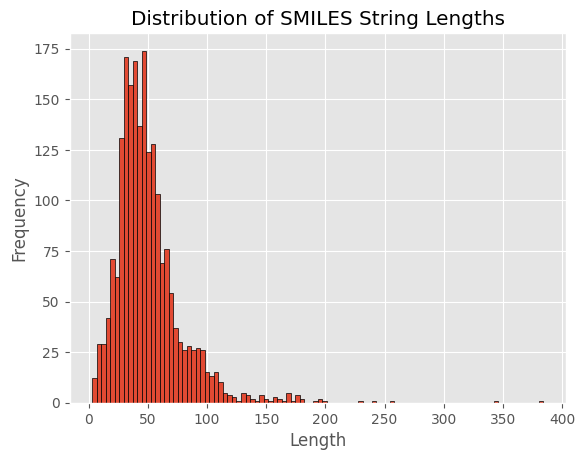

In [20]:
smiles_lengths = []
for i in df['processed_smiles']:
  smiles_lengths.append(len(i))
plt.hist(smiles_lengths, bins=100, edgecolor='black')
plt.title('Distribution of SMILES String Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

Fully connected Network

In [33]:
def encode_and_pad(smiles_series, max_length, encoding_dict):
    encoded_smiles = []
    for smiles in smiles_series:
        encoded = [encoding_dict[char] for char in smiles]
        # Pad the encoded SMILES with zero vectors at the first
        while len(encoded) < max_length:
            encoded.insert(0, np.zeros_like(encoded[0]))
        encoded_smiles.append(encoded)
    return np.array(encoded_smiles)

encoded_padded_smiles = encode_and_pad(df['processed_smiles'], smiles_p_maxlen, my_dict)

In [34]:
df['char_val'] = list(encoded_padded_smiles)
df['char_val'] = df['char_val'].apply(lambda x: np.array(x, dtype=np.float32))
encoded_padded_smiles.shape
df.head(3)

,name,smiles,p_np,processed_smiles,char_val
0,Propanolol,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1,[L].CC(C)NCC(O)COc1cccc2ccccc12,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Terbutylchlorambucil,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCL)CCL,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,40730,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [23]:
def acc_plot(loss_values,accuracy_values, train):
  plt.figure(figsize=(12, 3))

  plt.subplot(1, 3, 1)
  plt.plot(loss_values, 'b:')  # Blue dashed line
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)

  plt.subplot(1, 3, 3)
  plt.plot(accuracy_values, 'g:')  # Green solid line
  plt.title('Test Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Test Accuracy (%)')
  plt.ylim(0, 100)
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.plot(train, 'r:')  # Red dotted line
  plt.title('Train Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Train Accuracy (%)')
  plt.ylim(0, 100)
  plt.grid(True)

  plt.tight_layout()
  plt.show()


In [25]:
class DataLoaderCreator:
    def __init__(self, df, test_size=0.1, batch_size=16, random_state=2):
        self.df = df
        self.test_size = test_size
        self.batch_size = batch_size
        self.random_state = random_state

    def create_data_loaders(self):
        # Perform the train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.df['char_val'].tolist(), self.df['p_np'],
                                                            test_size=self.test_size, random_state=self.random_state)

        # Convert lists in X_train and X_test to numpy arrays
        X_train = np.array(X_train, dtype=np.float32)
        X_test = np.array(X_test, dtype=np.float32)

        # Convert data into PyTorch tensors
        X_train_tensor = torch.from_numpy(X_train)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
        X_test_tensor = torch.from_numpy(X_test)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

        # Create TensorDatasets
        train_data = TensorDataset(X_train_tensor, y_train_tensor)
        test_data = TensorDataset(X_test_tensor, y_test_tensor)

        # Create DataLoaders
        train_loader = DataLoader(train_data, shuffle=True, batch_size=self.batch_size)
        test_loader = DataLoader(test_data, shuffle=True, batch_size=self.batch_size)

        return train_loader, test_loader


In [26]:
data_loader_creator = DataLoaderCreator(df)
train_loader, test_loader = data_loader_creator.create_data_loaders()
batch = 16


In [37]:
# torch.Size([1845, 384, 40])
model_fully = nn.Sequential(
    nn.Linear(384*40, 512),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)
model_fully = model_fully.to(device)

In [39]:
random.seed(32)
criterion_fully = nn.BCELoss()
optimizer_fully = torch.optim.Adam(model_fully.parameters(), lr= 0.0005)
scheduler_fully = StepLR(optimizer_fully, step_size=2, gamma=0.7)
#####################################################################################

loss_values = []
accuracy_values = []
accuracy_train_values = []

for epoch in range(15):
    run_loss = 0
    correct_t = 0
    for X_batch_fully, y_batch_fully in tqdm(train_loader):
      X_batch_fully , y_batch_fully = X_batch_fully.to(device) , y_batch_fully.to(device)
      flattened_data = X_batch_fully.view(X_batch_fully.size(0), -1)
      
        
      # Forward pass
      y_pred = model_fully(flattened_data)

      loss = criterion_fully(y_pred.squeeze(1), y_batch_fully)

      # Backward pass and optimization
      optimizer_fully.zero_grad()
      loss.backward()
      optimizer_fully.step()
      run_loss += loss.item()

      predicted = torch.round(y_pred)
      correct_t += (predicted == y_batch_fully.unsqueeze(1)).sum().item()
    scheduler_fully.step()
    accuracy_train = correct_t / (len(train_loader)*batch)
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch , y_batch = X_batch.to(device) , y_batch.to(device)
            flattened_data = X_batch.view(X_batch.size(0), -1)
            y_pred = model_fully(flattened_data)
            predicted = torch.round(y_pred)
            correct += (predicted == y_batch.unsqueeze(1)).sum().item()

    accuracy_test = correct / (len(test_loader)*batch)
    accuracy_values.append(float(accuracy_test)*100)
    accuracy_train_values.append(float(accuracy_train)*100)
    loss_values.append(float(run_loss))
    print(f'Epoch = {epoch+1}, Train loss = {run_loss}, Train accuracy = {accuracy_train*100}%, Test accuracy = {accuracy_test * 100}%')

100%|██████████| 116/116 [00:00<00:00, 205.51it/s]


Epoch = 1, Train loss = 28.98231787374243, Train accuracy = 88.57758620689656%, Test accuracy = 90.38461538461539%


100%|██████████| 116/116 [00:00<00:00, 210.28it/s]


Epoch = 2, Train loss = 21.78125112876296, Train accuracy = 91.8103448275862%, Test accuracy = 90.86538461538461%


100%|██████████| 116/116 [00:00<00:00, 210.23it/s]


Epoch = 3, Train loss = 16.481476375833154, Train accuracy = 94.77370689655173%, Test accuracy = 91.82692307692307%


100%|██████████| 116/116 [00:00<00:00, 208.92it/s]


Epoch = 4, Train loss = 13.614981573075056, Train accuracy = 95.58189655172413%, Test accuracy = 90.86538461538461%


100%|██████████| 116/116 [00:00<00:00, 211.57it/s]


Epoch = 5, Train loss = 11.241397748235613, Train accuracy = 96.33620689655173%, Test accuracy = 91.34615384615384%


100%|██████████| 116/116 [00:00<00:00, 209.23it/s]


Epoch = 6, Train loss = 9.770603630458936, Train accuracy = 96.875%, Test accuracy = 91.34615384615384%


100%|██████████| 116/116 [00:00<00:00, 215.35it/s]


Epoch = 7, Train loss = 8.272632030304521, Train accuracy = 97.2521551724138%, Test accuracy = 90.86538461538461%


100%|██████████| 116/116 [00:00<00:00, 212.39it/s]


Epoch = 8, Train loss = 7.542568284086883, Train accuracy = 97.52155172413794%, Test accuracy = 90.38461538461539%


100%|██████████| 116/116 [00:00<00:00, 214.20it/s]


Epoch = 9, Train loss = 6.853983337059617, Train accuracy = 97.95258620689656%, Test accuracy = 92.3076923076923%


100%|██████████| 116/116 [00:00<00:00, 212.74it/s]


Epoch = 10, Train loss = 6.259470998309553, Train accuracy = 98.0603448275862%, Test accuracy = 90.38461538461539%


100%|██████████| 116/116 [00:00<00:00, 215.18it/s]


Epoch = 11, Train loss = 5.973837638972327, Train accuracy = 98.11422413793103%, Test accuracy = 90.38461538461539%


100%|██████████| 116/116 [00:00<00:00, 215.58it/s]


Epoch = 12, Train loss = 5.58650156002841, Train accuracy = 98.4375%, Test accuracy = 90.86538461538461%


100%|██████████| 116/116 [00:00<00:00, 212.11it/s]


Epoch = 13, Train loss = 5.123746508616023, Train accuracy = 98.54525862068965%, Test accuracy = 90.86538461538461%


100%|██████████| 116/116 [00:00<00:00, 214.68it/s]


Epoch = 14, Train loss = 4.964824220747687, Train accuracy = 98.4375%, Test accuracy = 91.82692307692307%


100%|██████████| 116/116 [00:00<00:00, 213.99it/s]

Epoch = 15, Train loss = 5.102078977273777, Train accuracy = 98.70689655172413%, Test accuracy = 90.86538461538461%


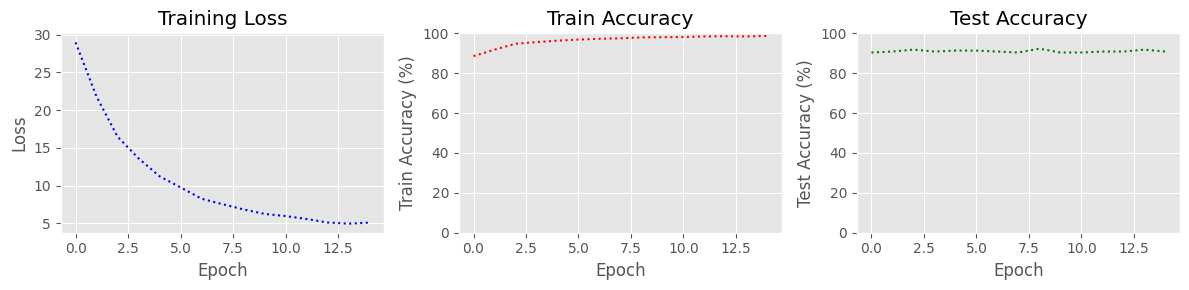

In [40]:
acc_plot(loss_values,accuracy_values,accuracy_train_values)

LSTM

In [45]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, bidirectional):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.n_layers = n_layers if not bidirectional else 2*n_layers
        self.fc_input_dim = hidden_dim if not bidirectional else 2*hidden_dim

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectional, dropout=0.5)

        # Batch Normalization layer
        self.batchnorm = nn.BatchNorm1d(self.fc_input_dim)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.fc_input_dim, 256),
                                nn.Dropout(0.5),
                                nn.ReLU(),
                                nn.Linear(256, 1),
                                nn.Sigmoid()
                                )

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Apply batch normalization to the outputs of the LSTM layer
        out = self.batchnorm(out[:, -1, :])

        out = self.fc(out)
        return out


In [46]:
class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [50]:
random.seed(32)
hidden_dim = 64
n_layers  = 2

model_LSTM = LSTMNet(input_dim=40, hidden_dim=hidden_dim, n_layers=n_layers, bidirectional=False)
model_LSTM = model_LSTM.to(device)
criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(model_LSTM.parameters(), lr= 0.0005)
scheduler_lstm = StepLR(optimizer_lstm, step_size=2, gamma=0.7)
noise = GaussianNoise( std = 0.1)


loss_values = []
accuracy_values = []
accuracy_train_values = []

for epoch in range(50):
    run_loss = 0
    correct_t = 0

    # Training loop
    model_LSTM.train()
    for X_batch, y_batch in tqdm(train_loader):
        
        X_batch = noise(X_batch)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_lstm.zero_grad()

        y_pred = model_LSTM(X_batch)
        loss = criterion_lstm(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer_lstm.step()

        run_loss += loss.item()

        predicted = torch.round(y_pred)
        correct_t += (predicted == y_batch.unsqueeze(1)).sum().item()
        accuracy_train = correct_t / len(train_loader.dataset)

    scheduler_lstm.step()
    # Evaluation loop
    model_LSTM.eval()
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model_LSTM(X_batch)
            predicted = torch.round(y_pred)
            correct += (predicted == y_batch.unsqueeze(1)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    accuracy_values.append(float(accuracy)*100)
    accuracy_train_values.append(float(accuracy_train)*100)
    loss_values.append(float(run_loss))

    print(f'Epoch = {epoch+1}, Train loss = {run_loss}, Train accuracy = {accuracy_train*100}%, Test accuracy = {accuracy * 100}%')




100%|██████████| 116/116 [00:00<00:00, 138.03it/s]


Epoch = 1, Train loss = 64.59658652544022, Train accuracy = 71.27371273712737%, Test accuracy = 80.97560975609757%


100%|██████████| 116/116 [00:00<00:00, 137.98it/s]


Epoch = 2, Train loss = 59.58860817551613, Train accuracy = 75.17615176151762%, Test accuracy = 78.53658536585367%


100%|██████████| 116/116 [00:00<00:00, 135.71it/s]


Epoch = 3, Train loss = 57.89156147837639, Train accuracy = 78.80758807588076%, Test accuracy = 85.85365853658537%


100%|██████████| 116/116 [00:00<00:00, 133.75it/s]


Epoch = 4, Train loss = 57.13285931944847, Train accuracy = 80.48780487804879%, Test accuracy = 82.92682926829268%


100%|██████████| 116/116 [00:00<00:00, 143.64it/s]


Epoch = 5, Train loss = 57.02030834555626, Train accuracy = 80.86720867208672%, Test accuracy = 85.36585365853658%


100%|██████████| 116/116 [00:00<00:00, 137.29it/s]


Epoch = 6, Train loss = 56.802653044462204, Train accuracy = 81.84281842818429%, Test accuracy = 87.8048780487805%


100%|██████████| 116/116 [00:00<00:00, 144.73it/s]


Epoch = 7, Train loss = 56.480474174022675, Train accuracy = 82.00542005420054%, Test accuracy = 85.85365853658537%


100%|██████████| 116/116 [00:00<00:00, 143.63it/s]


Epoch = 8, Train loss = 56.797217696905136, Train accuracy = 80.86720867208672%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 138.52it/s]


Epoch = 9, Train loss = 55.928660184144974, Train accuracy = 83.68563685636856%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 140.43it/s]


Epoch = 10, Train loss = 56.75919610261917, Train accuracy = 82.11382113821138%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 144.93it/s]


Epoch = 11, Train loss = 56.31888648867607, Train accuracy = 82.49322493224932%, Test accuracy = 89.26829268292683%


100%|██████████| 116/116 [00:00<00:00, 145.44it/s]


Epoch = 12, Train loss = 55.59173426032066, Train accuracy = 84.71544715447155%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 138.75it/s]


Epoch = 13, Train loss = 55.42462429404259, Train accuracy = 85.31165311653116%, Test accuracy = 89.26829268292683%


100%|██████████| 116/116 [00:00<00:00, 142.14it/s]


Epoch = 14, Train loss = 55.7762157022953, Train accuracy = 84.44444444444444%, Test accuracy = 91.21951219512195%


100%|██████████| 116/116 [00:00<00:00, 137.98it/s]


Epoch = 15, Train loss = 55.99280318617821, Train accuracy = 83.90243902439025%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 134.59it/s]


Epoch = 16, Train loss = 55.381253361701965, Train accuracy = 84.66124661246613%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 139.26it/s]


Epoch = 17, Train loss = 55.57952708005905, Train accuracy = 84.66124661246613%, Test accuracy = 91.21951219512195%


100%|██████████| 116/116 [00:00<00:00, 144.68it/s]


Epoch = 18, Train loss = 55.49172759056091, Train accuracy = 84.49864498644986%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 144.02it/s]


Epoch = 19, Train loss = 55.681569427251816, Train accuracy = 84.0650406504065%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 140.67it/s]


Epoch = 20, Train loss = 55.40294402837753, Train accuracy = 84.5528455284553%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 144.42it/s]


Epoch = 21, Train loss = 54.84600231051445, Train accuracy = 85.58265582655827%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 138.46it/s]


Epoch = 22, Train loss = 55.453914403915405, Train accuracy = 84.28184281842819%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 137.87it/s]


Epoch = 23, Train loss = 55.38336938619614, Train accuracy = 84.8780487804878%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 138.48it/s]


Epoch = 24, Train loss = 55.40048107504845, Train accuracy = 85.31165311653116%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 136.81it/s]


Epoch = 25, Train loss = 55.434607088565826, Train accuracy = 84.98644986449865%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 129.67it/s]


Epoch = 26, Train loss = 55.716327756643295, Train accuracy = 83.90243902439025%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 122.51it/s]


Epoch = 27, Train loss = 55.27483522891998, Train accuracy = 84.98644986449865%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 142.39it/s]


Epoch = 28, Train loss = 55.55855718255043, Train accuracy = 84.49864498644986%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 134.22it/s]


Epoch = 29, Train loss = 55.43082404136658, Train accuracy = 84.49864498644986%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 140.78it/s]


Epoch = 30, Train loss = 55.922313302755356, Train accuracy = 83.95663956639567%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 141.22it/s]


Epoch = 31, Train loss = 55.455929309129715, Train accuracy = 84.0650406504065%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 143.38it/s]


Epoch = 32, Train loss = 55.24447935819626, Train accuracy = 85.04065040650407%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 140.39it/s]


Epoch = 33, Train loss = 56.033169865608215, Train accuracy = 84.01084010840108%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 135.95it/s]


Epoch = 34, Train loss = 55.64010301232338, Train accuracy = 83.57723577235772%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 141.02it/s]


Epoch = 35, Train loss = 55.39717933535576, Train accuracy = 85.58265582655827%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 137.11it/s]


Epoch = 36, Train loss = 55.06276822090149, Train accuracy = 86.07046070460704%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 139.35it/s]


Epoch = 37, Train loss = 55.67522120475769, Train accuracy = 84.28184281842819%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 140.60it/s]


Epoch = 38, Train loss = 55.14905405044556, Train accuracy = 85.1490514905149%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 136.57it/s]


Epoch = 39, Train loss = 55.40161916613579, Train accuracy = 84.71544715447155%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 140.53it/s]


Epoch = 40, Train loss = 55.6694658100605, Train accuracy = 84.49864498644986%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 141.19it/s]


Epoch = 41, Train loss = 55.66224077343941, Train accuracy = 84.22764227642277%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 144.55it/s]


Epoch = 42, Train loss = 55.80106112360954, Train accuracy = 84.11924119241192%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 138.19it/s]


Epoch = 43, Train loss = 55.36734339594841, Train accuracy = 85.1490514905149%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 143.76it/s]


Epoch = 44, Train loss = 55.9653422832489, Train accuracy = 83.41463414634146%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 145.94it/s]


Epoch = 45, Train loss = 55.438617408275604, Train accuracy = 85.42005420054201%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 147.90it/s]


Epoch = 46, Train loss = 55.67439576983452, Train accuracy = 84.28184281842819%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 146.01it/s]


Epoch = 47, Train loss = 55.435362696647644, Train accuracy = 85.04065040650407%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 144.37it/s]


Epoch = 48, Train loss = 55.80521282553673, Train accuracy = 84.39024390243902%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 140.96it/s]


Epoch = 49, Train loss = 55.84397140145302, Train accuracy = 84.49864498644986%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 137.56it/s]

Epoch = 50, Train loss = 55.25402981042862, Train accuracy = 85.04065040650407%, Test accuracy = 90.2439024390244%


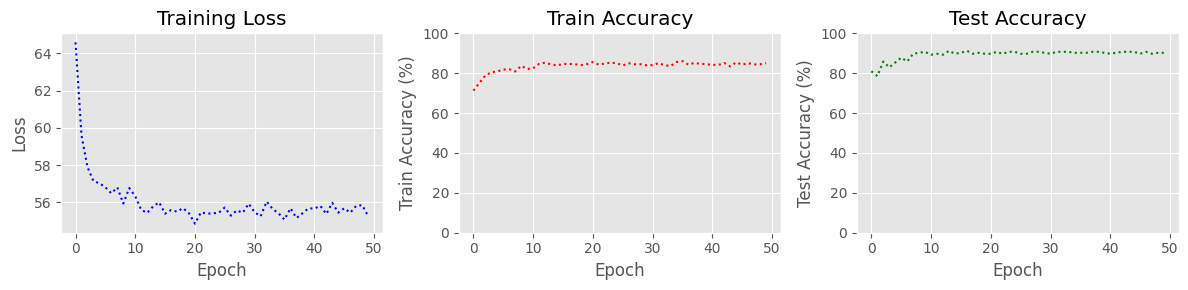

In [51]:
acc_plot(loss_values,accuracy_values,accuracy_train_values)

Bidirectional LSTM

In [53]:
random.seed(32)
hidden_dim = 64
n_layers  = 2

model_LSTM_B = LSTMNet(input_dim= 40, hidden_dim=hidden_dim, n_layers=n_layers, bidirectional=True)
model_LSTM_B = model_LSTM_B.to(device)

criterion_lstm_B = nn.BCEWithLogitsLoss()
optimizer_lstm_B = torch.optim.Adam(model_LSTM_B.parameters() , lr= 0.0005)
scheduler_B = StepLR(optimizer_lstm_B, step_size=2, gamma=0.7)
noise = GaussianNoise( std = 0.1)

loss_values = []
accuracy_values = []
accuracy_train_values = []

for epoch in range(50):
    run_loss = 0
    correct_t = 0

    # Training loop
    model_LSTM_B.train()
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = noise(X_batch)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_lstm_B.zero_grad()

        y_pred = model_LSTM_B(X_batch)
        loss = criterion_lstm_B(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer_lstm_B.step()

        run_loss += loss.item()

        predicted = torch.round(y_pred)
        correct_t += (predicted == y_batch.unsqueeze(1)).sum().item()
        accuracy_train = correct_t / len(train_loader.dataset)

    scheduler_B.step()
    # Evaluation loop
    model_LSTM_B.eval()
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model_LSTM_B(X_batch)
            predicted = torch.round(y_pred)
            correct += (predicted == y_batch.unsqueeze(1)).sum().item()
    accuracy_test = correct /  len(test_loader.dataset)
    accuracy_values.append(float(accuracy_test)*100)
    accuracy_train_values.append(float(accuracy_train)*100)
    loss_values.append(float(run_loss))
    print(f'Epoch = {epoch+1}, Train loss = {run_loss}, Train accuracy = {accuracy_train*100}%, Test accuracy = {accuracy_test * 100}%')




100%|██████████| 116/116 [00:01<00:00, 105.52it/s]


Epoch = 1, Train loss = 64.20666000247002, Train accuracy = 70.78590785907859%, Test accuracy = 82.4390243902439%


100%|██████████| 116/116 [00:00<00:00, 125.28it/s]


Epoch = 2, Train loss = 59.328546941280365, Train accuracy = 74.90514905149051%, Test accuracy = 62.4390243902439%


100%|██████████| 116/116 [00:00<00:00, 123.53it/s]


Epoch = 3, Train loss = 57.65683653950691, Train accuracy = 80.0%, Test accuracy = 72.1951219512195%


100%|██████████| 116/116 [00:00<00:00, 126.57it/s]


Epoch = 4, Train loss = 57.223483860492706, Train accuracy = 80.21680216802169%, Test accuracy = 86.34146341463415%


100%|██████████| 116/116 [00:00<00:00, 128.35it/s]


Epoch = 5, Train loss = 56.88416197896004, Train accuracy = 81.46341463414633%, Test accuracy = 83.41463414634146%


100%|██████████| 116/116 [00:00<00:00, 126.03it/s]


Epoch = 6, Train loss = 56.98220041394234, Train accuracy = 80.65040650406505%, Test accuracy = 86.82926829268293%


100%|██████████| 116/116 [00:00<00:00, 116.60it/s]


Epoch = 7, Train loss = 56.46739161014557, Train accuracy = 81.46341463414633%, Test accuracy = 87.3170731707317%


100%|██████████| 116/116 [00:00<00:00, 118.96it/s]


Epoch = 8, Train loss = 56.58771947026253, Train accuracy = 80.92140921409214%, Test accuracy = 88.78048780487805%


100%|██████████| 116/116 [00:00<00:00, 122.16it/s]


Epoch = 9, Train loss = 56.29875087738037, Train accuracy = 82.87262872628727%, Test accuracy = 88.78048780487805%


100%|██████████| 116/116 [00:00<00:00, 121.95it/s]


Epoch = 10, Train loss = 55.98406034708023, Train accuracy = 82.92682926829268%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 123.60it/s]


Epoch = 11, Train loss = 55.650437742471695, Train accuracy = 84.22764227642277%, Test accuracy = 89.26829268292683%


100%|██████████| 116/116 [00:00<00:00, 122.06it/s]


Epoch = 12, Train loss = 55.92378759384155, Train accuracy = 83.63143631436314%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 124.97it/s]


Epoch = 13, Train loss = 55.609663903713226, Train accuracy = 83.84823848238483%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 127.52it/s]


Epoch = 14, Train loss = 56.251004070043564, Train accuracy = 81.68021680216803%, Test accuracy = 91.21951219512195%


100%|██████████| 116/116 [00:00<00:00, 130.08it/s]


Epoch = 15, Train loss = 55.687220722436905, Train accuracy = 83.57723577235772%, Test accuracy = 91.21951219512195%


100%|██████████| 116/116 [00:00<00:00, 131.23it/s]


Epoch = 16, Train loss = 55.64112749695778, Train accuracy = 84.01084010840108%, Test accuracy = 89.26829268292683%


100%|██████████| 116/116 [00:00<00:00, 120.66it/s]


Epoch = 17, Train loss = 55.56365892291069, Train accuracy = 83.68563685636856%, Test accuracy = 91.21951219512195%


100%|██████████| 116/116 [00:00<00:00, 123.07it/s]


Epoch = 18, Train loss = 55.33204960823059, Train accuracy = 84.98644986449865%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 126.06it/s]


Epoch = 19, Train loss = 55.66386365890503, Train accuracy = 84.11924119241192%, Test accuracy = 89.26829268292683%


100%|██████████| 116/116 [00:00<00:00, 126.11it/s]


Epoch = 20, Train loss = 55.36904385685921, Train accuracy = 83.95663956639567%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 128.76it/s]


Epoch = 21, Train loss = 55.00161695480347, Train accuracy = 85.09485094850947%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 125.19it/s]


Epoch = 22, Train loss = 55.19241791963577, Train accuracy = 85.25745257452574%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 124.21it/s]


Epoch = 23, Train loss = 55.71950164437294, Train accuracy = 84.0650406504065%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 126.15it/s]


Epoch = 24, Train loss = 55.47450205683708, Train accuracy = 84.39024390243902%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 118.86it/s]


Epoch = 25, Train loss = 55.27903860807419, Train accuracy = 84.33604336043359%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 127.37it/s]


Epoch = 26, Train loss = 55.658725798130035, Train accuracy = 84.22764227642277%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 127.65it/s]


Epoch = 27, Train loss = 54.84139442443848, Train accuracy = 85.31165311653116%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 123.56it/s]


Epoch = 28, Train loss = 55.24867531657219, Train accuracy = 84.93224932249322%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 127.19it/s]


Epoch = 29, Train loss = 55.61533945798874, Train accuracy = 84.33604336043359%, Test accuracy = 91.21951219512195%


100%|██████████| 116/116 [00:00<00:00, 129.03it/s]


Epoch = 30, Train loss = 54.99033609032631, Train accuracy = 84.6070460704607%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 126.31it/s]


Epoch = 31, Train loss = 55.21797752380371, Train accuracy = 84.5528455284553%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 123.92it/s]


Epoch = 32, Train loss = 55.76445060968399, Train accuracy = 83.84823848238483%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 120.93it/s]


Epoch = 33, Train loss = 54.596893936395645, Train accuracy = 86.34146341463415%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:01<00:00, 101.98it/s]


Epoch = 34, Train loss = 55.27646800875664, Train accuracy = 84.39024390243902%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 129.29it/s]


Epoch = 35, Train loss = 55.151721477508545, Train accuracy = 85.42005420054201%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 129.51it/s]


Epoch = 36, Train loss = 55.16925311088562, Train accuracy = 84.71544715447155%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 127.65it/s]


Epoch = 37, Train loss = 55.38920319080353, Train accuracy = 84.66124661246613%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 122.53it/s]


Epoch = 38, Train loss = 55.33208030462265, Train accuracy = 84.49864498644986%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 131.58it/s]


Epoch = 39, Train loss = 55.59721142053604, Train accuracy = 83.84823848238483%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 128.43it/s]


Epoch = 40, Train loss = 55.25098091363907, Train accuracy = 84.76964769647697%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 129.76it/s]


Epoch = 41, Train loss = 55.48599150776863, Train accuracy = 84.11924119241192%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 128.00it/s]


Epoch = 42, Train loss = 55.336730152368546, Train accuracy = 84.22764227642277%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 130.20it/s]


Epoch = 43, Train loss = 55.744211316108704, Train accuracy = 83.73983739837398%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 125.77it/s]


Epoch = 44, Train loss = 55.4216710627079, Train accuracy = 84.0650406504065%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 123.66it/s]


Epoch = 45, Train loss = 55.46437427401543, Train accuracy = 84.17344173441734%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 127.14it/s]


Epoch = 46, Train loss = 55.23696890473366, Train accuracy = 84.49864498644986%, Test accuracy = 89.75609756097562%


100%|██████████| 116/116 [00:00<00:00, 129.34it/s]


Epoch = 47, Train loss = 55.13141471147537, Train accuracy = 85.04065040650407%, Test accuracy = 90.73170731707317%


100%|██████████| 116/116 [00:00<00:00, 119.43it/s]


Epoch = 48, Train loss = 55.34125563502312, Train accuracy = 84.44444444444444%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 128.02it/s]


Epoch = 49, Train loss = 55.20070308446884, Train accuracy = 84.6070460704607%, Test accuracy = 90.2439024390244%


100%|██████████| 116/116 [00:00<00:00, 129.45it/s]

Epoch = 50, Train loss = 55.60789492726326, Train accuracy = 83.95663956639567%, Test accuracy = 90.2439024390244%


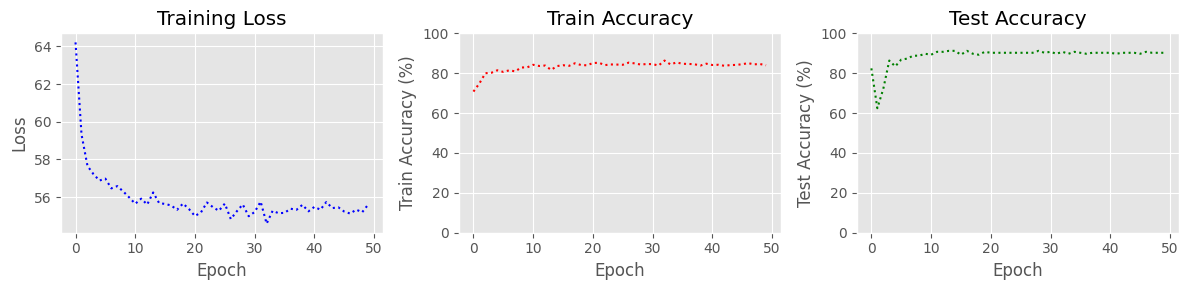

In [54]:
acc_plot(loss_values,accuracy_values,accuracy_train_values)

K Fold

In [55]:
from sklearn.model_selection import KFold

# Define the number of folds
n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=22)

# Convert your data into a numpy array
X = np.array(encoded_padded_smiles)
y = np.array(df['p_np'])
noise = GaussianNoise( std = 0.1)

accuracy_fold_train = []
accuracy_fold_test = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
    print(f'FOLD {fold+1}')

    # Prepare the training and validation data
    X_train, X_val = X[train_ids], X[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]

    # Convert data into PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create TensorDatasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    val_data = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

    # Initialize the model
    hidden_dim = 64
    n_layers  = 2
    model_LSTM = LSTMNet(input_dim=40, hidden_dim=hidden_dim, n_layers=n_layers, bidirectional=False)
    model_LSTM = model_LSTM.to(device)
    criterion_lstm = nn.BCEWithLogitsLoss()
    optimizer_lstm = torch.optim.Adam(model_LSTM.parameters(), lr= 0.0005)
    scheduler = StepLR(optimizer_lstm, step_size=2, gamma=0.7)

    noise = GaussianNoise( std = 0.1)
    loss_values = []
    accuracy_values = []
    accuracy_train_values = []

    # Training loop
    for epoch in range(20):
        run_loss = 0
        correct_t = 0

        model_LSTM.train()
        for X_batch, y_batch in tqdm(train_loader):
            X_batch = noise(X_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer_lstm.zero_grad()

            y_pred = model_LSTM(X_batch)
            loss = criterion_lstm(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer_lstm.step()

            run_loss += loss.item()

            predicted = torch.round(y_pred)
            correct_t += (predicted == y_batch.unsqueeze(1)).sum().item()
            accuracy_train = correct_t / (len(train_loader)*batch)
        scheduler.step()

        # Validation loop
        model_LSTM.eval()
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model_LSTM(X_batch)
                predicted = torch.round(y_pred)
                correct += (predicted == y_batch.unsqueeze(1)).sum().item()

        accuracy = correct / len(val_data)
        accuracy_values.append(float(accuracy))
        accuracy_train_values.append(float(accuracy_train))
        loss_values.append(float(run_loss))
        print(f'Epoch = {epoch+1}, Train loss = {run_loss}, Train accuracy = {accuracy_train*100}%, Validation accuracy = {accuracy * 100}%')
    print(f'Maximum accuracy in Fold={fold+1} in train= {max(accuracy_train_values)*100}%, in test= {max(accuracy_values)*100}%')
    accuracy_fold_train.append(max(accuracy_train_values))
    accuracy_fold_test.append(max(accuracy_values))


FOLD 1


100%|██████████| 103/103 [00:00<00:00, 132.37it/s]


Epoch = 1, Train loss = 56.92502707242966, Train accuracy = 71.90533980582524%, Validation accuracy = 74.8780487804878%


100%|██████████| 103/103 [00:00<00:00, 127.55it/s]


Epoch = 2, Train loss = 52.720680862665176, Train accuracy = 75.4247572815534%, Validation accuracy = 72.92682926829268%


100%|██████████| 103/103 [00:01<00:00, 101.13it/s]


Epoch = 3, Train loss = 51.44214504957199, Train accuracy = 77.5485436893204%, Validation accuracy = 46.09756097560976%


100%|██████████| 103/103 [00:00<00:00, 140.21it/s]


Epoch = 4, Train loss = 50.613365650177, Train accuracy = 78.7621359223301%, Validation accuracy = 77.8048780487805%


100%|██████████| 103/103 [00:00<00:00, 126.28it/s]


Epoch = 5, Train loss = 50.112458139657974, Train accuracy = 80.88592233009709%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 143.58it/s]


Epoch = 6, Train loss = 49.703467190265656, Train accuracy = 81.85679611650485%, Validation accuracy = 87.5609756097561%


100%|██████████| 103/103 [00:00<00:00, 135.86it/s]


Epoch = 7, Train loss = 49.82672077417374, Train accuracy = 81.49271844660194%, Validation accuracy = 85.1219512195122%


100%|██████████| 103/103 [00:00<00:00, 143.27it/s]


Epoch = 8, Train loss = 49.25989744067192, Train accuracy = 82.82766990291263%, Validation accuracy = 88.29268292682927%


100%|██████████| 103/103 [00:00<00:00, 135.00it/s]


Epoch = 9, Train loss = 49.45179736614227, Train accuracy = 82.8883495145631%, Validation accuracy = 85.1219512195122%


100%|██████████| 103/103 [00:00<00:00, 133.30it/s]


Epoch = 10, Train loss = 49.28204622864723, Train accuracy = 83.31310679611651%, Validation accuracy = 86.09756097560975%


100%|██████████| 103/103 [00:00<00:00, 142.88it/s]


Epoch = 11, Train loss = 49.46595084667206, Train accuracy = 82.03883495145631%, Validation accuracy = 86.09756097560975%


100%|██████████| 103/103 [00:00<00:00, 140.35it/s]


Epoch = 12, Train loss = 49.23392489552498, Train accuracy = 83.7985436893204%, Validation accuracy = 87.07317073170732%


100%|██████████| 103/103 [00:00<00:00, 139.46it/s]


Epoch = 13, Train loss = 49.23010802268982, Train accuracy = 83.25242718446601%, Validation accuracy = 88.78048780487805%


100%|██████████| 103/103 [00:00<00:00, 141.93it/s]


Epoch = 14, Train loss = 48.933365046978, Train accuracy = 84.40533980582524%, Validation accuracy = 85.36585365853658%


100%|██████████| 103/103 [00:00<00:00, 144.26it/s]


Epoch = 15, Train loss = 48.90044030547142, Train accuracy = 83.85922330097088%, Validation accuracy = 87.8048780487805%


100%|██████████| 103/103 [00:00<00:00, 144.44it/s]


Epoch = 16, Train loss = 48.59330278635025, Train accuracy = 85.07281553398059%, Validation accuracy = 87.5609756097561%


100%|██████████| 103/103 [00:00<00:00, 138.06it/s]


Epoch = 17, Train loss = 48.376299530267715, Train accuracy = 85.0121359223301%, Validation accuracy = 87.07317073170732%


100%|██████████| 103/103 [00:00<00:00, 140.38it/s]


Epoch = 18, Train loss = 49.03609472513199, Train accuracy = 83.49514563106796%, Validation accuracy = 87.8048780487805%


100%|██████████| 103/103 [00:00<00:00, 137.17it/s]


Epoch = 19, Train loss = 48.79766696691513, Train accuracy = 83.7985436893204%, Validation accuracy = 86.82926829268293%


100%|██████████| 103/103 [00:00<00:00, 136.59it/s]


Epoch = 20, Train loss = 49.03807184100151, Train accuracy = 83.7378640776699%, Validation accuracy = 86.82926829268293%
Maximum accuracy in Fold=1 in train= 85.07281553398059%, in test= 88.78048780487805%
FOLD 2


100%|██████████| 103/103 [00:00<00:00, 142.59it/s]


Epoch = 1, Train loss = 57.548293113708496, Train accuracy = 68.87135922330097%, Validation accuracy = 75.1219512195122%


100%|██████████| 103/103 [00:00<00:00, 132.29it/s]


Epoch = 2, Train loss = 53.15226790308952, Train accuracy = 74.27184466019418%, Validation accuracy = 78.53658536585367%


100%|██████████| 103/103 [00:00<00:00, 141.60it/s]


Epoch = 3, Train loss = 51.89553013443947, Train accuracy = 76.33495145631069%, Validation accuracy = 56.09756097560976%


100%|██████████| 103/103 [00:00<00:00, 139.76it/s]


Epoch = 4, Train loss = 51.02497774362564, Train accuracy = 79.85436893203884%, Validation accuracy = 72.6829268292683%


100%|██████████| 103/103 [00:00<00:00, 137.33it/s]


Epoch = 5, Train loss = 50.88589307665825, Train accuracy = 80.88592233009709%, Validation accuracy = 78.53658536585367%


100%|██████████| 103/103 [00:00<00:00, 143.33it/s]


Epoch = 6, Train loss = 50.13318654894829, Train accuracy = 82.64563106796116%, Validation accuracy = 76.09756097560975%


100%|██████████| 103/103 [00:00<00:00, 142.98it/s]


Epoch = 7, Train loss = 50.574736684560776, Train accuracy = 80.76456310679612%, Validation accuracy = 76.09756097560975%


100%|██████████| 103/103 [00:00<00:00, 145.11it/s]


Epoch = 8, Train loss = 50.47507956624031, Train accuracy = 81.12864077669903%, Validation accuracy = 81.95121951219512%


100%|██████████| 103/103 [00:00<00:00, 137.73it/s]


Epoch = 9, Train loss = 50.267803221940994, Train accuracy = 81.91747572815534%, Validation accuracy = 80.0%


100%|██████████| 103/103 [00:00<00:00, 141.56it/s]


Epoch = 10, Train loss = 49.94347620010376, Train accuracy = 82.34223300970875%, Validation accuracy = 82.68292682926828%


100%|██████████| 103/103 [00:00<00:00, 135.54it/s]


Epoch = 11, Train loss = 50.26806500554085, Train accuracy = 81.97815533980582%, Validation accuracy = 81.46341463414633%


100%|██████████| 103/103 [00:00<00:00, 132.52it/s]


Epoch = 12, Train loss = 50.125297874212265, Train accuracy = 81.91747572815534%, Validation accuracy = 83.65853658536585%


100%|██████████| 103/103 [00:00<00:00, 143.33it/s]


Epoch = 13, Train loss = 50.070648074150085, Train accuracy = 82.40291262135922%, Validation accuracy = 85.36585365853658%


100%|██████████| 103/103 [00:00<00:00, 129.96it/s]


Epoch = 14, Train loss = 49.87860333919525, Train accuracy = 82.76699029126213%, Validation accuracy = 82.92682926829268%


100%|██████████| 103/103 [00:00<00:00, 132.75it/s]


Epoch = 15, Train loss = 50.07050943374634, Train accuracy = 82.40291262135922%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 133.50it/s]


Epoch = 16, Train loss = 49.73195421695709, Train accuracy = 83.25242718446601%, Validation accuracy = 81.46341463414633%


100%|██████████| 103/103 [00:00<00:00, 134.10it/s]


Epoch = 17, Train loss = 49.48900884389877, Train accuracy = 82.8883495145631%, Validation accuracy = 83.65853658536585%


100%|██████████| 103/103 [00:00<00:00, 138.76it/s]


Epoch = 18, Train loss = 49.864462077617645, Train accuracy = 83.25242718446601%, Validation accuracy = 84.14634146341463%


100%|██████████| 103/103 [00:00<00:00, 134.31it/s]


Epoch = 19, Train loss = 49.58506119251251, Train accuracy = 83.19174757281553%, Validation accuracy = 84.14634146341463%


100%|██████████| 103/103 [00:00<00:00, 142.97it/s]


Epoch = 20, Train loss = 49.85965332388878, Train accuracy = 83.37378640776699%, Validation accuracy = 83.65853658536585%
Maximum accuracy in Fold=2 in train= 83.37378640776699%, in test= 85.36585365853658%
FOLD 3


100%|██████████| 103/103 [00:01<00:00, 97.79it/s]


Epoch = 1, Train loss = 57.105735778808594, Train accuracy = 73.54368932038835%, Validation accuracy = 75.85365853658537%


100%|██████████| 103/103 [00:00<00:00, 134.55it/s]


Epoch = 2, Train loss = 52.31190639734268, Train accuracy = 76.27427184466019%, Validation accuracy = 64.8780487804878%


100%|██████████| 103/103 [00:00<00:00, 140.68it/s]


Epoch = 3, Train loss = 50.85197305679321, Train accuracy = 80.15776699029125%, Validation accuracy = 64.39024390243902%


100%|██████████| 103/103 [00:00<00:00, 135.95it/s]


Epoch = 4, Train loss = 50.6061055958271, Train accuracy = 80.21844660194175%, Validation accuracy = 61.951219512195124%


100%|██████████| 103/103 [00:00<00:00, 133.21it/s]


Epoch = 5, Train loss = 50.55908542871475, Train accuracy = 80.21844660194175%, Validation accuracy = 82.92682926829268%


100%|██████████| 103/103 [00:00<00:00, 133.71it/s]


Epoch = 6, Train loss = 50.50297266244888, Train accuracy = 80.0364077669903%, Validation accuracy = 84.8780487804878%


100%|██████████| 103/103 [00:00<00:00, 137.70it/s]


Epoch = 7, Train loss = 49.94600799679756, Train accuracy = 82.03883495145631%, Validation accuracy = 85.60975609756098%


100%|██████████| 103/103 [00:00<00:00, 132.92it/s]


Epoch = 8, Train loss = 49.95679894089699, Train accuracy = 83.00970873786407%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 140.05it/s]


Epoch = 9, Train loss = 50.08722212910652, Train accuracy = 82.4635922330097%, Validation accuracy = 83.17073170731707%


100%|██████████| 103/103 [00:00<00:00, 141.62it/s]


Epoch = 10, Train loss = 50.258647203445435, Train accuracy = 81.43203883495146%, Validation accuracy = 83.17073170731707%


100%|██████████| 103/103 [00:00<00:00, 136.50it/s]


Epoch = 11, Train loss = 49.613372057676315, Train accuracy = 83.25242718446601%, Validation accuracy = 85.60975609756098%


100%|██████████| 103/103 [00:00<00:00, 141.21it/s]


Epoch = 12, Train loss = 49.690300434827805, Train accuracy = 84.1626213592233%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 144.33it/s]


Epoch = 13, Train loss = 49.73109722137451, Train accuracy = 82.82766990291263%, Validation accuracy = 84.6341463414634%


100%|██████████| 103/103 [00:00<00:00, 144.38it/s]


Epoch = 14, Train loss = 49.633639961481094, Train accuracy = 83.43446601941747%, Validation accuracy = 87.3170731707317%


100%|██████████| 103/103 [00:00<00:00, 141.52it/s]


Epoch = 15, Train loss = 49.92939272522926, Train accuracy = 82.4635922330097%, Validation accuracy = 85.1219512195122%


100%|██████████| 103/103 [00:00<00:00, 130.33it/s]


Epoch = 16, Train loss = 49.54216402769089, Train accuracy = 82.76699029126213%, Validation accuracy = 84.8780487804878%


100%|██████████| 103/103 [00:00<00:00, 141.12it/s]


Epoch = 17, Train loss = 49.383570939302444, Train accuracy = 83.07038834951457%, Validation accuracy = 84.8780487804878%


100%|██████████| 103/103 [00:00<00:00, 141.34it/s]


Epoch = 18, Train loss = 49.832300901412964, Train accuracy = 82.16019417475728%, Validation accuracy = 84.39024390243902%


100%|██████████| 103/103 [00:00<00:00, 134.98it/s]


Epoch = 19, Train loss = 50.10532373189926, Train accuracy = 81.73543689320388%, Validation accuracy = 86.58536585365853%


100%|██████████| 103/103 [00:00<00:00, 139.85it/s]


Epoch = 20, Train loss = 49.588886976242065, Train accuracy = 82.8883495145631%, Validation accuracy = 85.36585365853658%
Maximum accuracy in Fold=3 in train= 84.1626213592233%, in test= 87.3170731707317%
FOLD 4


100%|██████████| 103/103 [00:00<00:00, 134.48it/s]


Epoch = 1, Train loss = 57.279935002326965, Train accuracy = 74.1504854368932%, Validation accuracy = 75.60975609756098%


100%|██████████| 103/103 [00:00<00:00, 134.65it/s]


Epoch = 2, Train loss = 52.72059601545334, Train accuracy = 76.27427184466019%, Validation accuracy = 67.8048780487805%


100%|██████████| 103/103 [00:00<00:00, 139.80it/s]


Epoch = 3, Train loss = 51.31305143237114, Train accuracy = 78.88349514563106%, Validation accuracy = 80.48780487804879%


100%|██████████| 103/103 [00:00<00:00, 135.40it/s]


Epoch = 4, Train loss = 50.43994325399399, Train accuracy = 81.43203883495146%, Validation accuracy = 78.53658536585367%


100%|██████████| 103/103 [00:00<00:00, 135.56it/s]


Epoch = 5, Train loss = 50.78948947787285, Train accuracy = 81.06796116504854%, Validation accuracy = 83.65853658536585%


100%|██████████| 103/103 [00:00<00:00, 135.97it/s]


Epoch = 6, Train loss = 49.806801557540894, Train accuracy = 83.61650485436894%, Validation accuracy = 82.92682926829268%


100%|██████████| 103/103 [00:00<00:00, 132.17it/s]


Epoch = 7, Train loss = 49.9008395075798, Train accuracy = 82.8883495145631%, Validation accuracy = 81.46341463414633%


100%|██████████| 103/103 [00:00<00:00, 142.75it/s]


Epoch = 8, Train loss = 50.093936026096344, Train accuracy = 82.52427184466019%, Validation accuracy = 80.2439024390244%


100%|██████████| 103/103 [00:00<00:00, 141.47it/s]


Epoch = 9, Train loss = 49.82459968328476, Train accuracy = 82.64563106796116%, Validation accuracy = 83.65853658536585%


100%|██████████| 103/103 [00:00<00:00, 130.95it/s]


Epoch = 10, Train loss = 49.757016479969025, Train accuracy = 83.00970873786407%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 136.08it/s]


Epoch = 11, Train loss = 49.29124653339386, Train accuracy = 83.7985436893204%, Validation accuracy = 83.41463414634146%


100%|██████████| 103/103 [00:00<00:00, 134.35it/s]


Epoch = 12, Train loss = 49.30130761861801, Train accuracy = 84.28398058252428%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 137.85it/s]


Epoch = 13, Train loss = 49.49359527230263, Train accuracy = 83.85922330097088%, Validation accuracy = 84.14634146341463%


100%|██████████| 103/103 [00:00<00:00, 139.39it/s]


Epoch = 14, Train loss = 49.6917062997818, Train accuracy = 83.61650485436894%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 142.97it/s]


Epoch = 15, Train loss = 49.63206985592842, Train accuracy = 83.07038834951457%, Validation accuracy = 83.41463414634146%


100%|██████████| 103/103 [00:00<00:00, 135.76it/s]


Epoch = 16, Train loss = 49.31156373023987, Train accuracy = 84.28398058252428%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 139.69it/s]


Epoch = 17, Train loss = 49.26600429415703, Train accuracy = 83.7985436893204%, Validation accuracy = 83.90243902439025%


100%|██████████| 103/103 [00:00<00:00, 140.31it/s]


Epoch = 18, Train loss = 49.04895403981209, Train accuracy = 85.19417475728154%, Validation accuracy = 84.14634146341463%


100%|██████████| 103/103 [00:00<00:00, 119.96it/s]


Epoch = 19, Train loss = 49.68554374575615, Train accuracy = 84.34466019417476%, Validation accuracy = 84.14634146341463%


100%|██████████| 103/103 [00:00<00:00, 137.88it/s]


Epoch = 20, Train loss = 49.22283178567886, Train accuracy = 84.1626213592233%, Validation accuracy = 84.39024390243902%
Maximum accuracy in Fold=4 in train= 85.19417475728154%, in test= 84.39024390243902%
FOLD 5


100%|██████████| 103/103 [00:00<00:00, 136.06it/s]


Epoch = 1, Train loss = 57.046699941158295, Train accuracy = 72.26941747572816%, Validation accuracy = 79.51219512195122%


100%|██████████| 103/103 [00:00<00:00, 142.95it/s]


Epoch = 2, Train loss = 52.889091461896896, Train accuracy = 73.96844660194175%, Validation accuracy = 82.92682926829268%


100%|██████████| 103/103 [00:00<00:00, 132.12it/s]


Epoch = 3, Train loss = 51.48240241408348, Train accuracy = 77.9126213592233%, Validation accuracy = 82.92682926829268%


100%|██████████| 103/103 [00:00<00:00, 143.06it/s]


Epoch = 4, Train loss = 51.21564403176308, Train accuracy = 78.3373786407767%, Validation accuracy = 78.78048780487805%


100%|██████████| 103/103 [00:00<00:00, 140.29it/s]


Epoch = 5, Train loss = 50.31573957204819, Train accuracy = 80.70388349514563%, Validation accuracy = 85.1219512195122%


100%|██████████| 103/103 [00:00<00:00, 141.98it/s]


Epoch = 6, Train loss = 50.35562989115715, Train accuracy = 81.25%, Validation accuracy = 87.07317073170732%


100%|██████████| 103/103 [00:00<00:00, 143.75it/s]


Epoch = 7, Train loss = 50.34960210323334, Train accuracy = 81.31067961165049%, Validation accuracy = 82.92682926829268%


100%|██████████| 103/103 [00:00<00:00, 141.69it/s]


Epoch = 8, Train loss = 50.34852707386017, Train accuracy = 81.55339805825243%, Validation accuracy = 85.60975609756098%


100%|██████████| 103/103 [00:00<00:00, 133.65it/s]


Epoch = 9, Train loss = 49.682245165109634, Train accuracy = 83.19174757281553%, Validation accuracy = 85.85365853658537%


100%|██████████| 103/103 [00:00<00:00, 145.03it/s]


Epoch = 10, Train loss = 50.065003246068954, Train accuracy = 81.55339805825243%, Validation accuracy = 85.36585365853658%


100%|██████████| 103/103 [00:00<00:00, 137.87it/s]


Epoch = 11, Train loss = 49.72169044613838, Train accuracy = 82.4635922330097%, Validation accuracy = 87.5609756097561%


100%|██████████| 103/103 [00:00<00:00, 145.14it/s]


Epoch = 12, Train loss = 49.63535752892494, Train accuracy = 82.34223300970875%, Validation accuracy = 85.36585365853658%


100%|██████████| 103/103 [00:00<00:00, 136.91it/s]


Epoch = 13, Train loss = 49.54502683877945, Train accuracy = 83.13106796116504%, Validation accuracy = 85.85365853658537%


100%|██████████| 103/103 [00:00<00:00, 137.63it/s]


Epoch = 14, Train loss = 49.28619149327278, Train accuracy = 83.13106796116504%, Validation accuracy = 87.5609756097561%


100%|██████████| 103/103 [00:00<00:00, 128.45it/s]


Epoch = 15, Train loss = 49.37791529297829, Train accuracy = 83.67718446601941%, Validation accuracy = 87.8048780487805%


100%|██████████| 103/103 [00:00<00:00, 141.92it/s]


Epoch = 16, Train loss = 49.3724989593029, Train accuracy = 83.37378640776699%, Validation accuracy = 88.04878048780488%


100%|██████████| 103/103 [00:00<00:00, 140.22it/s]


Epoch = 17, Train loss = 49.36637118458748, Train accuracy = 83.07038834951457%, Validation accuracy = 86.82926829268293%


100%|██████████| 103/103 [00:00<00:00, 142.22it/s]


Epoch = 18, Train loss = 49.123411148786545, Train accuracy = 84.28398058252428%, Validation accuracy = 87.07317073170732%


100%|██████████| 103/103 [00:00<00:00, 130.25it/s]


Epoch = 19, Train loss = 49.48363783955574, Train accuracy = 83.55582524271846%, Validation accuracy = 87.07317073170732%


100%|██████████| 103/103 [00:00<00:00, 142.64it/s]


Epoch = 20, Train loss = 49.18844375014305, Train accuracy = 83.19174757281553%, Validation accuracy = 87.07317073170732%
Maximum accuracy in Fold=5 in train= 84.28398058252428%, in test= 88.04878048780488%


In [56]:
def plot_result(accuracy_fold_train,accuracy_fold_test):
    plt.bar([0.9,1.9,2.9,3.9,4.9],[i * 100 for i in accuracy_fold_train],
    label="Train accuracy",color='b',width=0.2)
    plt.bar([1.1,2.1,3.1,4.1,5.1],[i * 100 for i in accuracy_fold_test],
    label="Train accuracy", color='g',width=.2)
    plt.legend()
    plt.xlabel('FOLD')
    plt.ylabel('accuracy')
#     pyplot.title('Details')
    plt.show()

The best accuracy 
on train= 85.19417475728154%
on test= 88.78048780487805%


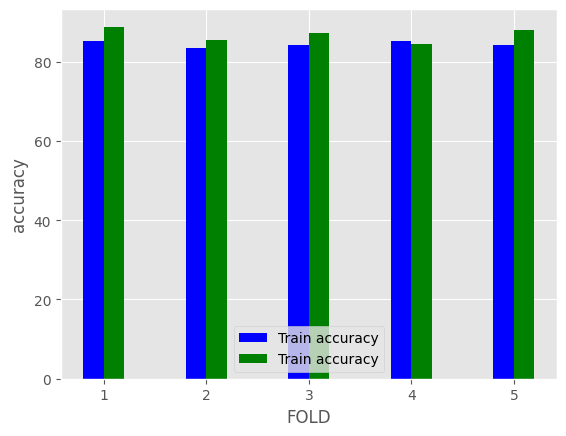

In [57]:
print(f'The best accuracy \non train= {max(accuracy_fold_train)*100}%\non test= {max(accuracy_fold_test)*100}%')
plot_result(accuracy_fold_train,accuracy_fold_test)


In [61]:
# Define the number of folds
n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=22)

# Convert your data into a numpy array
X = np.array(encoded_padded_smiles)
y = np.array(df['p_np'])
noise = GaussianNoise( std = 0.3)


accuracy_fold_train = []
accuracy_fold_test = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(X)):
    print(f'FOLD {fold+1}')

    # Prepare the training and validation data
    X_train, X_val = X[train_ids], X[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]

    # Convert data into PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # Create TensorDatasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    val_data = TensorDataset(X_val_tensor, y_val_tensor)

    # Create DataLoaders
    batch_size = 10
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

    # Initialize the model
    hidden_dim = 64
    n_layers  = 2
    model_LSTM_B = LSTMNet(input_dim=40, hidden_dim=hidden_dim, n_layers=n_layers, bidirectional=False)
    model_LSTM_B = model_LSTM_B.to(device)
    criterion_lstm_B = nn.BCEWithLogitsLoss()
    optimizer_lstm_B = torch.optim.Adam(model_LSTM_B.parameters(), lr= 0.0005)
    scheduler_B = StepLR(optimizer_lstm_B, step_size=2, gamma=0.7)
    noise = GaussianNoise( std = 0.1)
    loss_values = []
    accuracy_values = []
    accuracy_train_values = []

    # Training loop
    for epoch in range(20):
        run_loss = 0
        correct_t = 0

        model_LSTM_B.train()
        for X_batch, y_batch in tqdm(train_loader):
            X_batch = noise(X_batch)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer_lstm_B.zero_grad()

            y_pred = model_LSTM_B(X_batch)
            loss = criterion_lstm_B(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer_lstm_B.step()

            run_loss += loss.item()

            predicted = torch.round(y_pred)
            correct_t += (predicted == y_batch.unsqueeze(1)).sum().item()
            accuracy_train =correct_t /len(train_loader.dataset)

        scheduler_B.step()

        # Validation loop
        model_LSTM_B.eval()
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model_LSTM_B(X_batch)
                predicted = torch.round(y_pred)
                correct += (predicted == y_batch.unsqueeze(1)).sum().item()

        accuracy = correct / len(val_data)
        accuracy_values.append(float(accuracy))
        accuracy_train_values.append(float(accuracy_train))
        loss_values.append(float(run_loss))
        print(f'Epoch = {epoch+1}, Train loss = {run_loss}, Train accuracy = {accuracy_train*100}%, Validation accuracy = {accuracy * 100}%')
    print(f'Maximum accuracy in Fold={fold+1} in train= {max(accuracy_train_values)*100}%, in test= {max(accuracy_values)*100}%')
    accuracy_fold_train.append(max(accuracy_train_values))
    accuracy_fold_test.append(max(accuracy_values))


FOLD 1


100%|██████████| 164/164 [00:01<00:00, 155.76it/s]


Epoch = 1, Train loss = 89.74803936481476, Train accuracy = 72.3170731707317%, Validation accuracy = 77.5609756097561%


100%|██████████| 164/164 [00:01<00:00, 156.51it/s]


Epoch = 2, Train loss = 82.91112351417542, Train accuracy = 76.21951219512195%, Validation accuracy = 84.14634146341463%


100%|██████████| 164/164 [00:01<00:00, 146.26it/s]


Epoch = 3, Train loss = 81.46504211425781, Train accuracy = 78.71951219512195%, Validation accuracy = 82.68292682926828%


100%|██████████| 164/164 [00:00<00:00, 166.59it/s]


Epoch = 4, Train loss = 80.4272648692131, Train accuracy = 79.26829268292683%, Validation accuracy = 77.8048780487805%


100%|██████████| 164/164 [00:01<00:00, 154.32it/s]


Epoch = 5, Train loss = 80.3712964951992, Train accuracy = 80.60975609756098%, Validation accuracy = 77.07317073170732%


100%|██████████| 164/164 [00:00<00:00, 167.07it/s]


Epoch = 6, Train loss = 80.04491829872131, Train accuracy = 81.28048780487805%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:01<00:00, 163.92it/s]


Epoch = 7, Train loss = 79.82328701019287, Train accuracy = 81.28048780487805%, Validation accuracy = 81.46341463414633%


100%|██████████| 164/164 [00:01<00:00, 155.35it/s]


Epoch = 8, Train loss = 79.94578835368156, Train accuracy = 81.03658536585367%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:00<00:00, 165.46it/s]


Epoch = 9, Train loss = 78.78770112991333, Train accuracy = 82.6219512195122%, Validation accuracy = 85.85365853658537%


100%|██████████| 164/164 [00:01<00:00, 153.37it/s]


Epoch = 10, Train loss = 78.5832194685936, Train accuracy = 83.17073170731707%, Validation accuracy = 85.85365853658537%


100%|██████████| 164/164 [00:01<00:00, 151.27it/s]


Epoch = 11, Train loss = 79.98953899741173, Train accuracy = 80.73170731707317%, Validation accuracy = 85.85365853658537%


100%|██████████| 164/164 [00:01<00:00, 160.02it/s]


Epoch = 12, Train loss = 78.01094388961792, Train accuracy = 84.20731707317073%, Validation accuracy = 85.36585365853658%


100%|██████████| 164/164 [00:00<00:00, 164.25it/s]


Epoch = 13, Train loss = 78.24681475758553, Train accuracy = 83.96341463414633%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:00<00:00, 164.63it/s]


Epoch = 14, Train loss = 78.06851303577423, Train accuracy = 84.39024390243902%, Validation accuracy = 86.58536585365853%


100%|██████████| 164/164 [00:00<00:00, 169.39it/s]


Epoch = 15, Train loss = 78.00384470820427, Train accuracy = 83.96341463414633%, Validation accuracy = 86.82926829268293%


100%|██████████| 164/164 [00:00<00:00, 169.51it/s]


Epoch = 16, Train loss = 77.72658574581146, Train accuracy = 84.6951219512195%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:00<00:00, 167.91it/s]


Epoch = 17, Train loss = 77.82950860261917, Train accuracy = 84.57317073170731%, Validation accuracy = 84.8780487804878%


100%|██████████| 164/164 [00:00<00:00, 164.32it/s]


Epoch = 18, Train loss = 77.61406674981117, Train accuracy = 85.24390243902438%, Validation accuracy = 86.58536585365853%


100%|██████████| 164/164 [00:01<00:00, 155.98it/s]


Epoch = 19, Train loss = 77.53866627812386, Train accuracy = 84.57317073170731%, Validation accuracy = 86.09756097560975%


100%|██████████| 164/164 [00:01<00:00, 160.62it/s]


Epoch = 20, Train loss = 78.44706308841705, Train accuracy = 83.90243902439025%, Validation accuracy = 86.09756097560975%
Maximum accuracy in Fold=1 in train= 85.24390243902438%, in test= 86.82926829268293%
FOLD 2


100%|██████████| 164/164 [00:01<00:00, 162.35it/s]


Epoch = 1, Train loss = 90.01353687047958, Train accuracy = 71.64634146341463%, Validation accuracy = 71.95121951219512%


100%|██████████| 164/164 [00:01<00:00, 153.55it/s]


Epoch = 2, Train loss = 84.47293129563332, Train accuracy = 74.7560975609756%, Validation accuracy = 77.8048780487805%


100%|██████████| 164/164 [00:01<00:00, 162.53it/s]


Epoch = 3, Train loss = 81.88718354701996, Train accuracy = 78.29268292682927%, Validation accuracy = 61.46341463414634%


100%|██████████| 164/164 [00:01<00:00, 155.22it/s]


Epoch = 4, Train loss = 81.71404168009758, Train accuracy = 79.26829268292683%, Validation accuracy = 50.97560975609756%


100%|██████████| 164/164 [00:00<00:00, 165.81it/s]


Epoch = 5, Train loss = 80.84191170334816, Train accuracy = 80.91463414634147%, Validation accuracy = 71.46341463414633%


100%|██████████| 164/164 [00:00<00:00, 165.67it/s]


Epoch = 6, Train loss = 80.28235831856728, Train accuracy = 81.40243902439023%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:01<00:00, 149.36it/s]


Epoch = 7, Train loss = 80.70542219281197, Train accuracy = 80.79268292682927%, Validation accuracy = 81.95121951219512%


100%|██████████| 164/164 [00:01<00:00, 155.62it/s]


Epoch = 8, Train loss = 79.19141459465027, Train accuracy = 83.90243902439025%, Validation accuracy = 80.97560975609757%


100%|██████████| 164/164 [00:01<00:00, 161.89it/s]


Epoch = 9, Train loss = 80.32469636201859, Train accuracy = 81.34146341463413%, Validation accuracy = 84.14634146341463%


100%|██████████| 164/164 [00:01<00:00, 159.11it/s]


Epoch = 10, Train loss = 79.3731544315815, Train accuracy = 83.47560975609755%, Validation accuracy = 80.97560975609757%


100%|██████████| 164/164 [00:01<00:00, 123.39it/s]


Epoch = 11, Train loss = 79.39513176679611, Train accuracy = 83.29268292682926%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:01<00:00, 163.60it/s]


Epoch = 12, Train loss = 79.62713721394539, Train accuracy = 83.96341463414633%, Validation accuracy = 83.65853658536585%


100%|██████████| 164/164 [00:01<00:00, 161.36it/s]


Epoch = 13, Train loss = 78.71301782131195, Train accuracy = 83.90243902439025%, Validation accuracy = 84.6341463414634%


100%|██████████| 164/164 [00:00<00:00, 168.04it/s]


Epoch = 14, Train loss = 79.04939594864845, Train accuracy = 84.39024390243902%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:01<00:00, 156.98it/s]


Epoch = 15, Train loss = 78.78051072359085, Train accuracy = 83.04878048780488%, Validation accuracy = 86.58536585365853%


100%|██████████| 164/164 [00:00<00:00, 167.42it/s]


Epoch = 16, Train loss = 77.8214400112629, Train accuracy = 85.73170731707317%, Validation accuracy = 83.65853658536585%


100%|██████████| 164/164 [00:01<00:00, 158.50it/s]


Epoch = 17, Train loss = 78.8290263414383, Train accuracy = 84.14634146341463%, Validation accuracy = 84.39024390243902%


100%|██████████| 164/164 [00:00<00:00, 167.14it/s]


Epoch = 18, Train loss = 78.77512672543526, Train accuracy = 83.65853658536585%, Validation accuracy = 84.8780487804878%


100%|██████████| 164/164 [00:01<00:00, 162.18it/s]


Epoch = 19, Train loss = 79.35382944345474, Train accuracy = 83.35365853658536%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:00<00:00, 164.70it/s]


Epoch = 20, Train loss = 78.57383292913437, Train accuracy = 84.32926829268293%, Validation accuracy = 84.8780487804878%
Maximum accuracy in Fold=2 in train= 85.73170731707317%, in test= 86.58536585365853%
FOLD 3


100%|██████████| 164/164 [00:00<00:00, 166.54it/s]


Epoch = 1, Train loss = 91.04447689652443, Train accuracy = 71.70731707317073%, Validation accuracy = 78.29268292682927%


100%|██████████| 164/164 [00:00<00:00, 169.14it/s]


Epoch = 2, Train loss = 83.90237408876419, Train accuracy = 76.15853658536585%, Validation accuracy = 73.17073170731707%


100%|██████████| 164/164 [00:00<00:00, 167.00it/s]


Epoch = 3, Train loss = 82.10567456483841, Train accuracy = 78.17073170731707%, Validation accuracy = 82.4390243902439%


100%|██████████| 164/164 [00:00<00:00, 164.66it/s]


Epoch = 4, Train loss = 81.13511005043983, Train accuracy = 80.97560975609757%, Validation accuracy = 84.39024390243902%


100%|██████████| 164/164 [00:00<00:00, 166.84it/s]


Epoch = 5, Train loss = 80.57121232151985, Train accuracy = 80.85365853658537%, Validation accuracy = 84.6341463414634%


100%|██████████| 164/164 [00:01<00:00, 156.38it/s]


Epoch = 6, Train loss = 79.66503059864044, Train accuracy = 83.41463414634146%, Validation accuracy = 80.73170731707317%


100%|██████████| 164/164 [00:00<00:00, 164.95it/s]


Epoch = 7, Train loss = 79.50844550132751, Train accuracy = 82.2560975609756%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:01<00:00, 163.02it/s]


Epoch = 8, Train loss = 79.7967378795147, Train accuracy = 82.5%, Validation accuracy = 85.36585365853658%


100%|██████████| 164/164 [00:00<00:00, 166.79it/s]


Epoch = 9, Train loss = 79.68179816007614, Train accuracy = 82.4390243902439%, Validation accuracy = 85.60975609756098%


100%|██████████| 164/164 [00:01<00:00, 163.26it/s]


Epoch = 10, Train loss = 79.3829075396061, Train accuracy = 83.17073170731707%, Validation accuracy = 82.4390243902439%


100%|██████████| 164/164 [00:00<00:00, 166.25it/s]


Epoch = 11, Train loss = 78.55767270922661, Train accuracy = 84.32926829268293%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:00<00:00, 167.02it/s]


Epoch = 12, Train loss = 78.97893419861794, Train accuracy = 83.84146341463415%, Validation accuracy = 84.6341463414634%


100%|██████████| 164/164 [00:01<00:00, 160.82it/s]


Epoch = 13, Train loss = 79.0139631330967, Train accuracy = 83.35365853658536%, Validation accuracy = 85.60975609756098%


100%|██████████| 164/164 [00:01<00:00, 161.12it/s]


Epoch = 14, Train loss = 79.09630027413368, Train accuracy = 83.17073170731707%, Validation accuracy = 83.17073170731707%


100%|██████████| 164/164 [00:01<00:00, 156.92it/s]


Epoch = 15, Train loss = 79.25426781177521, Train accuracy = 83.29268292682926%, Validation accuracy = 84.14634146341463%


100%|██████████| 164/164 [00:01<00:00, 161.09it/s]


Epoch = 16, Train loss = 79.02939939498901, Train accuracy = 83.53658536585365%, Validation accuracy = 85.1219512195122%


100%|██████████| 164/164 [00:01<00:00, 161.00it/s]


Epoch = 17, Train loss = 78.92784243822098, Train accuracy = 82.80487804878048%, Validation accuracy = 85.36585365853658%


100%|██████████| 164/164 [00:00<00:00, 167.24it/s]


Epoch = 18, Train loss = 78.83089452981949, Train accuracy = 84.02439024390243%, Validation accuracy = 82.4390243902439%


100%|██████████| 164/164 [00:01<00:00, 135.31it/s]


Epoch = 19, Train loss = 78.57380121946335, Train accuracy = 83.35365853658536%, Validation accuracy = 84.6341463414634%


100%|██████████| 164/164 [00:01<00:00, 151.45it/s]


Epoch = 20, Train loss = 78.64306691288948, Train accuracy = 83.96341463414633%, Validation accuracy = 85.1219512195122%
Maximum accuracy in Fold=3 in train= 84.32926829268293%, in test= 85.60975609756098%
FOLD 4


100%|██████████| 164/164 [00:00<00:00, 169.39it/s]


Epoch = 1, Train loss = 90.81441390514374, Train accuracy = 71.76829268292683%, Validation accuracy = 49.26829268292683%


100%|██████████| 164/164 [00:00<00:00, 167.33it/s]


Epoch = 2, Train loss = 83.98239347338676, Train accuracy = 75.0609756097561%, Validation accuracy = 77.5609756097561%


100%|██████████| 164/164 [00:00<00:00, 164.84it/s]


Epoch = 3, Train loss = 82.2145584821701, Train accuracy = 77.92682926829269%, Validation accuracy = 73.17073170731707%


100%|██████████| 164/164 [00:01<00:00, 157.17it/s]


Epoch = 4, Train loss = 80.99567446112633, Train accuracy = 80.60975609756098%, Validation accuracy = 82.4390243902439%


100%|██████████| 164/164 [00:00<00:00, 164.73it/s]


Epoch = 5, Train loss = 79.62199595570564, Train accuracy = 83.71951219512195%, Validation accuracy = 84.39024390243902%


100%|██████████| 164/164 [00:00<00:00, 165.30it/s]


Epoch = 6, Train loss = 80.118671387434, Train accuracy = 82.2560975609756%, Validation accuracy = 82.92682926829268%


100%|██████████| 164/164 [00:00<00:00, 166.46it/s]


Epoch = 7, Train loss = 78.95739117264748, Train accuracy = 84.08536585365853%, Validation accuracy = 85.60975609756098%


100%|██████████| 164/164 [00:00<00:00, 166.89it/s]


Epoch = 8, Train loss = 78.81153756380081, Train accuracy = 84.32926829268293%, Validation accuracy = 83.17073170731707%


100%|██████████| 164/164 [00:01<00:00, 162.59it/s]


Epoch = 9, Train loss = 79.12136471271515, Train accuracy = 84.08536585365853%, Validation accuracy = 83.41463414634146%


100%|██████████| 164/164 [00:01<00:00, 159.17it/s]


Epoch = 10, Train loss = 79.85429692268372, Train accuracy = 83.04878048780488%, Validation accuracy = 84.14634146341463%


100%|██████████| 164/164 [00:00<00:00, 167.55it/s]


Epoch = 11, Train loss = 78.67111456394196, Train accuracy = 84.6341463414634%, Validation accuracy = 83.65853658536585%


100%|██████████| 164/164 [00:01<00:00, 163.21it/s]


Epoch = 12, Train loss = 79.444167137146, Train accuracy = 83.10975609756098%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:01<00:00, 157.98it/s]


Epoch = 13, Train loss = 79.46077567338943, Train accuracy = 83.96341463414633%, Validation accuracy = 85.36585365853658%


100%|██████████| 164/164 [00:00<00:00, 168.10it/s]


Epoch = 14, Train loss = 78.72132679820061, Train accuracy = 84.39024390243902%, Validation accuracy = 84.8780487804878%


100%|██████████| 164/164 [00:01<00:00, 162.29it/s]


Epoch = 15, Train loss = 79.04116091132164, Train accuracy = 84.45121951219512%, Validation accuracy = 84.14634146341463%


100%|██████████| 164/164 [00:00<00:00, 165.80it/s]


Epoch = 16, Train loss = 78.26330521702766, Train accuracy = 85.24390243902438%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:01<00:00, 157.18it/s]


Epoch = 17, Train loss = 78.54148861765862, Train accuracy = 84.14634146341463%, Validation accuracy = 83.17073170731707%


100%|██████████| 164/164 [00:00<00:00, 164.54it/s]


Epoch = 18, Train loss = 78.10735619068146, Train accuracy = 85.24390243902438%, Validation accuracy = 84.14634146341463%


100%|██████████| 164/164 [00:00<00:00, 168.40it/s]


Epoch = 19, Train loss = 78.44174838066101, Train accuracy = 84.39024390243902%, Validation accuracy = 84.6341463414634%


100%|██████████| 164/164 [00:00<00:00, 166.99it/s]


Epoch = 20, Train loss = 78.7697286605835, Train accuracy = 84.57317073170731%, Validation accuracy = 84.39024390243902%
Maximum accuracy in Fold=4 in train= 85.24390243902438%, in test= 85.60975609756098%
FOLD 5


100%|██████████| 164/164 [00:00<00:00, 164.04it/s]


Epoch = 1, Train loss = 90.39855143427849, Train accuracy = 73.59756097560975%, Validation accuracy = 79.75609756097562%


100%|██████████| 164/164 [00:01<00:00, 162.98it/s]


Epoch = 2, Train loss = 84.7447537779808, Train accuracy = 74.8170731707317%, Validation accuracy = 80.2439024390244%


100%|██████████| 164/164 [00:01<00:00, 150.90it/s]


Epoch = 3, Train loss = 81.68085578083992, Train accuracy = 79.08536585365854%, Validation accuracy = 83.90243902439025%


100%|██████████| 164/164 [00:00<00:00, 166.53it/s]


Epoch = 4, Train loss = 80.89961645007133, Train accuracy = 80.79268292682927%, Validation accuracy = 84.8780487804878%


100%|██████████| 164/164 [00:00<00:00, 168.88it/s]


Epoch = 5, Train loss = 80.24673515558243, Train accuracy = 81.40243902439023%, Validation accuracy = 86.09756097560975%


100%|██████████| 164/164 [00:01<00:00, 157.79it/s]


Epoch = 6, Train loss = 79.73004025220871, Train accuracy = 82.1341463414634%, Validation accuracy = 86.34146341463415%


100%|██████████| 164/164 [00:01<00:00, 150.86it/s]


Epoch = 7, Train loss = 79.37042340636253, Train accuracy = 83.71951219512195%, Validation accuracy = 87.8048780487805%


100%|██████████| 164/164 [00:00<00:00, 164.66it/s]


Epoch = 8, Train loss = 79.25066456198692, Train accuracy = 82.74390243902438%, Validation accuracy = 88.04878048780488%


100%|██████████| 164/164 [00:00<00:00, 167.75it/s]


Epoch = 9, Train loss = 79.61813256144524, Train accuracy = 82.92682926829268%, Validation accuracy = 88.78048780487805%


100%|██████████| 164/164 [00:00<00:00, 169.50it/s]


Epoch = 10, Train loss = 78.55145099759102, Train accuracy = 84.8780487804878%, Validation accuracy = 88.29268292682927%


100%|██████████| 164/164 [00:01<00:00, 161.44it/s]


Epoch = 11, Train loss = 78.39144894480705, Train accuracy = 83.90243902439025%, Validation accuracy = 88.04878048780488%


100%|██████████| 164/164 [00:00<00:00, 169.08it/s]


Epoch = 12, Train loss = 78.40837341547012, Train accuracy = 84.02439024390243%, Validation accuracy = 88.78048780487805%


100%|██████████| 164/164 [00:00<00:00, 168.31it/s]


Epoch = 13, Train loss = 78.59736213088036, Train accuracy = 84.26829268292683%, Validation accuracy = 88.53658536585365%


100%|██████████| 164/164 [00:00<00:00, 169.84it/s]


Epoch = 14, Train loss = 77.47970089316368, Train accuracy = 86.21951219512195%, Validation accuracy = 88.78048780487805%


100%|██████████| 164/164 [00:00<00:00, 164.30it/s]


Epoch = 15, Train loss = 77.56340056657791, Train accuracy = 85.67073170731707%, Validation accuracy = 87.3170731707317%


100%|██████████| 164/164 [00:01<00:00, 161.19it/s]


Epoch = 16, Train loss = 76.98572289943695, Train accuracy = 86.95121951219512%, Validation accuracy = 88.78048780487805%


100%|██████████| 164/164 [00:01<00:00, 159.10it/s]


Epoch = 17, Train loss = 77.6744991838932, Train accuracy = 85.24390243902438%, Validation accuracy = 87.3170731707317%


100%|██████████| 164/164 [00:00<00:00, 166.67it/s]


Epoch = 18, Train loss = 77.7531735599041, Train accuracy = 85.1829268292683%, Validation accuracy = 87.3170731707317%


100%|██████████| 164/164 [00:00<00:00, 167.16it/s]


Epoch = 19, Train loss = 78.19971737265587, Train accuracy = 84.51219512195122%, Validation accuracy = 87.8048780487805%


100%|██████████| 164/164 [00:01<00:00, 153.69it/s]

Epoch = 20, Train loss = 77.59654942154884, Train accuracy = 85.79268292682927%, Validation accuracy = 89.26829268292683%
Maximum accuracy in Fold=5 in train= 86.95121951219512%, in test= 89.26829268292683%


The best accuracy 
on train= 86.95121951219512%
on test= 89.26829268292683%


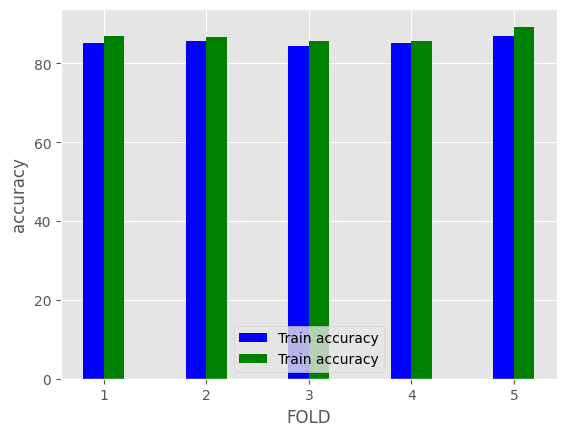

In [63]:
print(f'The best accuracy \non train= {max(accuracy_fold_train)*100}%\non test= {max(accuracy_fold_test)*100}%')
plot_result(accuracy_fold_train,accuracy_fold_test)

In [95]:
_, bin_dataframe = train_test_split(df, test_size=0.5, random_state=42)
bin_dataframe.drop(["name","processed_smiles"],axis=1,inplace=True)
bin_dataframe['lenghts'] = bin_dataframe['smiles'].str.len()
bin_dataframe["SetInd"] = pd.qcut(bin_dataframe['lenghts'], q=10, labels=False)
grouped = bin_dataframe.groupby('SetInd')
dataframes = [group for _, group in grouped]

dataLoaders = []
for dataframe in dataframes:
    dataframe.reset_index(drop=True, inplace=True)
    data_loader_creator = DataLoaderCreator(df)
    train_loader, test_loader = data_loader_creator.create_data_loaders()
    dataLoaders.append(train_loader)

In [114]:
def EvaluateModel(model, data_loaders,mod=None):
    idxs = []
    acc = []

    for idx, data_loader in enumerate(data_loaders):
        with torch.no_grad():
            correct_predictions = 0
            for (input_data, target) in data_loader:
                input_data, target = input_data.to(device), target.to(device)
                if mod  == 'fully':
                  input_data =  input_data.view(input_data.size(0), -1)
                model_output = model(input_data)
                predicted = torch.round(model_output)
                correct_t = (predicted == target.unsqueeze(1)).sum().item()
                correct_predictions += correct_t 
            accuracy = correct_predictions / len(data_loader.dataset)
            idxs.append(idx)
            acc.append(accuracy)
    return idxs, acc

def plot_ac(idxs,acc,title):
  plt.figure(figsize=(5, 3))
  plt.plot(idxs, acc, marker='o') 
  plt.title(title)
  plt.xlabel('Bin')
  plt.ylabel('Accuracy')
  plt.grid(True)
  plt.show()

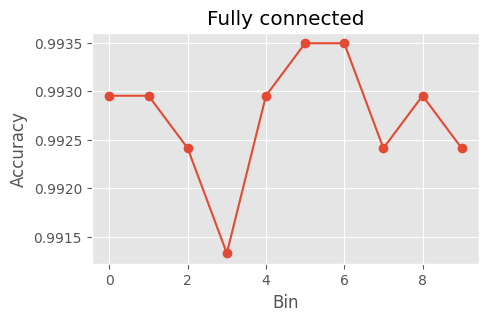

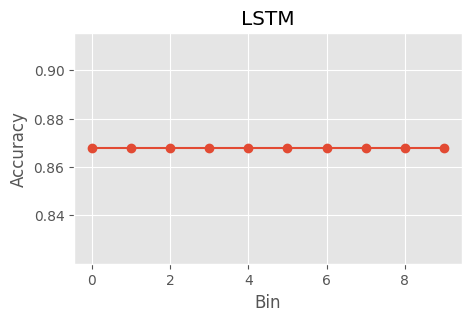

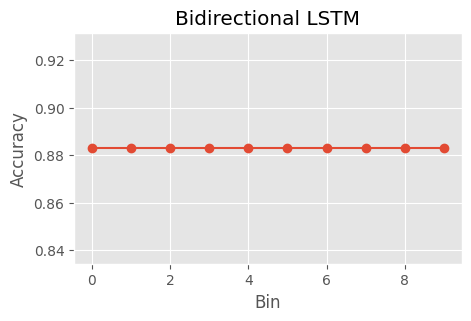

In [115]:
idxs, acc = EvaluateModel(model_fully,dataLoaders,'fully')
plot_ac(idxs,acc,'Fully connected')

idxs, acc = EvaluateModel(model_LSTM,dataLoaders)
plot_ac(idxs,acc,'LSTM')

idxs, acc = EvaluateModel(model_LSTM_B,dataLoaders)
plot_ac(idxs,acc,'Bidirectional LSTM')